# 1.	Research questions, select analyses, import data

### a. Define research questions

In [1]:
#RQ 1: Based on past data, what total revenue do we forecast for the next month?

### b.	Select analyses to answer research questions

In [2]:
#RQ 1: Quantitative Analysis: Ensemble Forecast using an ensemble of the following 6 forecasts: 
        #Holt-Winters Forecast
        #Facebook Prophet Forecast
        #Sarimax Forecast
        #TBATS Forecast
        #Tensorflow Probabilities Structural Time Series Forecast
        #Facebook Prophet with XGBoost

### c.	Import libraries

In [3]:
#Import frequent Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly as py
%matplotlib inline
import datetime as dt
import os
import winsound

### d. Import data

In [4]:
#Import the data from online and then get the data from one excel sheet
import requests
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
r = requests.get(url)
open('online_retail_II.xlsx','wb').write(r.content)
data1 = pd.read_excel('online_retail_II.xlsx', sheet_name = 'Year 2009-2010')
data1.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [5]:
#Get the data from a second excel sheet
data2 = pd.read_excel('online_retail_II.xlsx', sheet_name = 'Year 2010-2011')
data2.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
#Combine the data from both excel sheets by adding rows of one to the other
#Reorder the rows ascending based on date
#Check the beginning of the data frame
df=(pd.concat([data1,data2], axis=0)).sort_values(['InvoiceDate'],ascending=True)
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [7]:
#Check the end of the data frame
df.tail(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [8]:
#Get the number of rows and columns of the data
df.shape

(1067371, 8)

### e. Select a sample

In [9]:
#Take a random sample of 10% of the data to use for faster initial analysis.
df = df.sample(frac=0.1,random_state=101)
#See how many rows of data you have now
print(len(df))

106737


# 2.	Clean Columns

### a. Rename columns as desired

In [10]:
# Rename columns for clarity and make the changes permenant
df.rename(columns = {'InvoiceDate': 'Date', 'UnitPrice': 'Price'}, inplace=True)
df.head(2)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
223288,556478,21238,RED RETROSPOT CUP,20,2011-06-12 12:34:00,0.85,13069.0,United Kingdom
34477,539395,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,18,2010-12-17 11:52:00,2.10,12471.0,Germany


### b. Check for typos in a column with text

In [11]:
#List the values of a categorical variable column.
#Sort alphabetically.
#Check for any misspellings causing duplicate category names.
df['Country'].value_counts().sort_index(ascending=True)

Australia                 202
Austria                    83
Bahrain                    13
Belgium                   322
Bermuda                     4
Brazil                      4
Canada                     17
Channel Islands           169
Cyprus                    126
Czech Republic              4
Denmark                    76
EIRE                     1742
European Community          6
Finland                   113
France                   1419
Germany                  1768
Greece                     68
Hong Kong                  32
Iceland                    21
Israel                     43
Italy                     141
Japan                      68
Korea                      10
Lebanon                     7
Lithuania                  23
Malta                      30
Netherlands               534
Nigeria                     4
Norway                    150
Poland                     53
Portugal                  261
RSA                        17
Singapore                  40
Spain     

In [12]:
#Replace any misspelled values with the correct spellings and check the new values. Also prevent a warning from annoying you.
pd.options.mode.chained_assignment = None
df['Country'].replace(['Czech Republic'],'Czechia',inplace=True)
df['Country'].value_counts()

United Kingdom          98139
Germany                  1768
EIRE                     1742
France                   1419
Netherlands               534
Spain                     381
Switzerland               322
Belgium                   322
Portugal                  261
Australia                 202
Channel Islands           169
Norway                    150
Italy                     141
Sweden                    134
Cyprus                    126
Finland                   113
Austria                    83
Denmark                    76
Unspecified                73
Greece                     68
Japan                      68
United Arab Emirates       55
Poland                     53
USA                        52
Israel                     43
Singapore                  40
Hong Kong                  32
Malta                      30
Lithuania                  23
Iceland                    21
RSA                        17
Canada                     17
Bahrain                    13
Korea     

### c. Remove/replace null data in a column

In [13]:
#Get the total number of null values in each column.
df.isnull().sum()

Invoice            0
StockCode          0
Description      451
Quantity           0
Date               0
Price              0
Customer ID    24478
Country            0
dtype: int64

In [14]:
#Calculate the percentage of null values in each column, list descending, and format the result to two decimal places.
(df.isnull().sum()/len(df)).sort_values(ascending=False).apply('{:,.2%}'.format)

Customer ID    22.93%
Description     0.42%
Invoice         0.00%
StockCode       0.00%
Quantity        0.00%
Date            0.00%
Price           0.00%
Country         0.00%
dtype: object

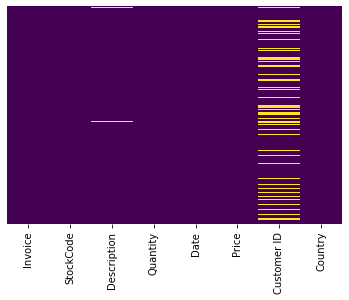

In [15]:
#See where we are missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [16]:
#Decide to remove or replace null values (replace through imputation for each column)
#We decide to remove all rows with null values. 
#Remove nulls then check the result.
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
Date           0
Price          0
Customer ID    0
Country        0
dtype: int64

In [17]:
#See the number of rows and columns we have now.
df.shape

(82259, 8)

### d. Reformat column data types as needed

In [18]:
#Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82259 entries, 223288 to 67733
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      82259 non-null  object        
 1   StockCode    82259 non-null  object        
 2   Description  82259 non-null  object        
 3   Quantity     82259 non-null  int64         
 4   Date         82259 non-null  datetime64[ns]
 5   Price        82259 non-null  float64       
 6   Customer ID  82259 non-null  float64       
 7   Country      82259 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [19]:
#Change a column's data type and check to see that it changed.
df = df.astype({"Customer ID": 'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82259 entries, 223288 to 67733
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      82259 non-null  object        
 1   StockCode    82259 non-null  object        
 2   Description  82259 non-null  object        
 3   Quantity     82259 non-null  int64         
 4   Date         82259 non-null  datetime64[ns]
 5   Price        82259 non-null  float64       
 6   Customer ID  82259 non-null  int64         
 7   Country      82259 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 5.6+ MB


# 3. Clean Rows

### a. Remove unnecessary rows for categorical variables

In [20]:
#See the unique values in a column
df['Country'].unique()

array(['United Kingdom', 'Germany', 'Switzerland', 'EIRE', 'Italy',
       'France', 'United Arab Emirates', 'Australia', 'USA', 'Norway',
       'Cyprus', 'Belgium', 'Spain', 'Finland', 'Malta', 'Netherlands',
       'Sweden', 'Thailand', 'Channel Islands', 'Canada', 'Austria',
       'Bahrain', 'Portugal', 'RSA', 'Singapore', 'Japan', 'Korea',
       'Greece', 'Poland', 'Czechia', 'Israel', 'Denmark', 'Unspecified',
       'European Community', 'Iceland', 'Lithuania', 'Nigeria',
       'West Indies', 'Lebanon', 'Brazil'], dtype=object)

In [21]:
#Remove rows for the value of a category that we do not need. 
#Keep only the rows in the data that do not include a certain categorical value in a column.
#Check the result
df=df[~df['Country'].isin(['Unspecified'])]
df['Country'].unique()

array(['United Kingdom', 'Germany', 'Switzerland', 'EIRE', 'Italy',
       'France', 'United Arab Emirates', 'Australia', 'USA', 'Norway',
       'Cyprus', 'Belgium', 'Spain', 'Finland', 'Malta', 'Netherlands',
       'Sweden', 'Thailand', 'Channel Islands', 'Canada', 'Austria',
       'Bahrain', 'Portugal', 'RSA', 'Singapore', 'Japan', 'Korea',
       'Greece', 'Poland', 'Czechia', 'Israel', 'Denmark',
       'European Community', 'Iceland', 'Lithuania', 'Nigeria',
       'West Indies', 'Lebanon', 'Brazil'], dtype=object)

### b. Remove unnecessary rows of numerical data

In [22]:
#Remove rows of items that were returned that have a 'C' in the stockcode.
#See how many rows are left.
df = df[~df['Invoice'].str.contains('C', na=False)]
df.shape

(80339, 8)

In [23]:
#Remove negative prices and negative quantities. We'll keep their initial orders.
#Keep only the rows that are greater than zero. 
#Check the resulting min and max.
df = df[df['Price'] > 0]
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,Price,Customer ID
count,80330.000000,80330.000000,80330.000000
mean,13.834346,3.406488,15331.577841
std,267.243861,53.198531,1697.849364
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13979.250000
50%,5.000000,1.950000,15271.000000
75%,12.000000,3.750000,16807.000000
max,74215.000000,10953.500000,18287.000000


### c. Remove rows outside of target timeframe

In [24]:
#Get the range of dates in the date column.
date_range = str(df['Date'].min()) + ' to ' + str(df['Date'].max())
date_range

'2009-12-01 07:46:00 to 2011-12-09 12:31:00'

In [25]:
#Remove rows with dates that are before or after the dates we want to include by only specifying the dates we want to include.
df=df.loc[(df['Date'] >= '2009-12-01 00:00:00') & (df['Date'] <= '2011-11-30 23:59:59')]
df.shape

(78588, 8)

In [26]:
#Get the range of dates in the date column.
date_range = str(df['Date'].min()) + ' to ' + str(df['Date'].max())
date_range

'2009-12-01 07:46:00 to 2011-11-30 17:37:00'

### d. Remove duplicate rows

In [27]:
#See how many rows are duplicates of another row
df.duplicated(subset=None, keep='first').sum()

288

In [28]:
#See a list of all duplicate rows (including the ones you want to keep) and sort them ascending using the CustomerID column and then the date column
df[df.duplicated(subset=None, keep=False)].sort_values(['Customer ID', 'Date', 'Description'])

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
17072,537676,22555,PLASTERS IN TIN STRONGMAN,12,2010-12-08 09:53:00,1.65,12386,Australia
520011,537676,22555,PLASTERS IN TIN STRONGMAN,12,2010-12-08 09:53:00,1.65,12386,Australia
522971,538003,22914,BLUE COAT RACK PARIS FASHION,6,2010-12-09 12:05:00,4.95,12429,Denmark
20033,538003,22914,BLUE COAT RACK PARIS FASHION,6,2010-12-09 12:05:00,4.95,12429,Denmark
522960,538003,22670,FRENCH WC SIGN BLUE METAL,36,2010-12-09 12:05:00,1.25,12429,Denmark
...,...,...,...,...,...,...,...,...
8109,537126,84596G,SMALL CHOCOLATES PINK BOWL,1,2010-12-05 12:13:00,1.25,18118,United Kingdom
511241,537133,22274,FELTCRAFT DOLL EMILY,1,2010-12-05 12:29:00,2.95,18156,United Kingdom
8297,537133,22274,FELTCRAFT DOLL EMILY,1,2010-12-05 12:29:00,2.95,18156,United Kingdom
200749,554157,23208,LUNCH BAG VINTAGE LEAF DESIGN,1,2011-05-23 11:33:00,1.65,18283,United Kingdom


In [29]:
#Remove duplicate rows and see how many rows you now have.
df.drop_duplicates(inplace=True)
df.shape

(78300, 8)

### e. Remove rows with outliers as appropriate

<AxesSubplot:ylabel='Quantity'>

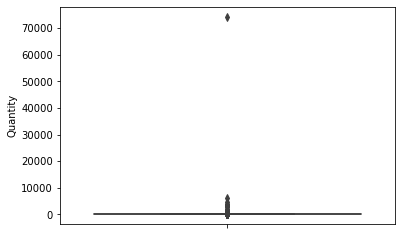

In [30]:
#Look at a boxplot of numerical columns to identify possible outliers
sns.boxplot(y='Quantity', data=df)

In [31]:
#Sort the values of the column descending to identify possible outliers
df.sort_values('Quantity', ascending=False).head(10)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
432177,530715,17003,BROCADE RING PURSE,6336,2010-11-04 11:36:00,0.19,15838,United Kingdom
358738,524174,85110,BLACK SILVER FLOWER T-LIGHT HOLDER,4752,2010-09-27 16:30:00,0.07,13687,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom
298935,518505,21392,RED SPOTTY PUDDING BOWL,3648,2010-08-09 13:10:00,0.13,14277,France
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008,United Kingdom
358736,524174,85160B,BLACK BIRD GARDEN DESIGN MUG,2976,2010-09-27 16:30:00,0.13,13687,United Kingdom
507883,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754,United Kingdom
432171,530714,21704,BAG 250g SWIRLY MARBLES,1944,2010-11-04 11:35:00,0.72,16754,United Kingdom
298918,518505,85006,SET 4 NURSERY DES ROUND BOXES,1440,2010-08-09 13:10:00,0.31,14277,France


In [32]:
#Remove outlier rows that may be mistakes and then recheck the data
df.drop(df[df['Quantity'] > 7000].index, axis=0, inplace = True)
df.sort_values('Quantity', ascending=False).head(5)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
432177,530715,17003,BROCADE RING PURSE,6336,2010-11-04 11:36:00,0.19,15838,United Kingdom
358738,524174,85110,BLACK SILVER FLOWER T-LIGHT HOLDER,4752,2010-09-27 16:30:00,0.07,13687,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom
298935,518505,21392,RED SPOTTY PUDDING BOWL,3648,2010-08-09 13:10:00,0.13,14277,France
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008,United Kingdom


<AxesSubplot:ylabel='Price'>

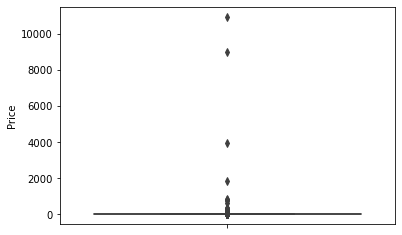

In [33]:
#Look at a boxplot of another numerical column to identify possible outliers
sns.boxplot(y='Price', data=df)

In [34]:
#Sort the values of the column descending to identify possible outliers
df.sort_values('Price', ascending=False).head(10)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918,United Kingdom
74356,496115,M,Manual,1,2010-01-29 11:04:00,8985.60,17949,United Kingdom
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
322140,520750,M,Manual,1,2010-08-31 11:04:00,1868.56,15480,Malta
228919,511520,M,Manual,1,2010-06-08 16:39:00,849.45,14308,United Kingdom
292749,517934,M,Manual,1,2010-08-03 10:52:00,800.00,12748,United Kingdom
48348,493900,M,Manual,1,2010-01-08 10:44:00,780.52,14911,EIRE
407877,528420,M,Manual,1,2010-10-22 09:45:00,780.25,14911,EIRE
416464,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,638.30,14096,United Kingdom
106398,545332,M,Manual,1,2011-03-01 15:52:00,376.50,12352,Norway


In [35]:
#Remove outlier rows that may be mistakes and recheck the data
df.drop(df[df['Price'] > 1000].index, axis=0, inplace = True)
df.sort_values('Price', ascending=False).head(5)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
228919,511520,M,Manual,1,2010-06-08 16:39:00,849.45,14308,United Kingdom
292749,517934,M,Manual,1,2010-08-03 10:52:00,800.00,12748,United Kingdom
48348,493900,M,Manual,1,2010-01-08 10:44:00,780.52,14911,EIRE
407877,528420,M,Manual,1,2010-10-22 09:45:00,780.25,14911,EIRE
416464,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,638.30,14096,United Kingdom


In [36]:
#Check how many rows you have now
df.shape

(78295, 8)

### f. Remove extra spaces in a column with text

In [37]:
#Remove leading and trailing white spaces from a column with strings
df['Country'] = df['Country'].str.strip()
df

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country
223288,556478,21238,RED RETROSPOT CUP,20,2011-06-12 12:34:00,0.85,13069,United Kingdom
34477,539395,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,18,2010-12-17 11:52:00,2.10,12471,Germany
364164,568650,23173,REGENCY TEAPOT ROSES,2,2011-09-28 11:56:00,9.95,13505,Switzerland
278743,516488,21531,RED RETROSPOT SUGAR JAM BOWL,6,2010-07-21 10:04:00,2.55,17865,United Kingdom
387657,570348,22961,JAM MAKING SET PRINTED,12,2011-10-10 12:28:00,1.45,16982,United Kingdom
...,...,...,...,...,...,...,...,...
475706,576910,22840,ROUND CAKE TIN VINTAGE RED,2,2011-11-17 09:51:00,7.95,12477,Germany
468228,533516,21984,PACK OF 12 PINK PAISLEY TISSUES,24,2010-11-17 14:53:00,0.25,16684,United Kingdom
430673,530543,47567B,TEA TIME KITCHEN APRON,2,2010-11-03 13:10:00,5.95,15005,United Kingdom
122520,546882,22798,ANTIQUE GLASS DRESSING TABLE POT,8,2011-03-17 17:26:00,2.95,14422,United Kingdom


### g. Set the Date Column as the Index

In [38]:
#Copy the Date Column to use later
df['Dates']=df['Date']
df.head(5)

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country,Dates
223288,556478,21238,RED RETROSPOT CUP,20,2011-06-12 12:34:00,0.85,13069,United Kingdom,2011-06-12 12:34:00
34477,539395,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,18,2010-12-17 11:52:00,2.10,12471,Germany,2010-12-17 11:52:00
364164,568650,23173,REGENCY TEAPOT ROSES,2,2011-09-28 11:56:00,9.95,13505,Switzerland,2011-09-28 11:56:00
278743,516488,21531,RED RETROSPOT SUGAR JAM BOWL,6,2010-07-21 10:04:00,2.55,17865,United Kingdom,2010-07-21 10:04:00
387657,570348,22961,JAM MAKING SET PRINTED,12,2011-10-10 12:28:00,1.45,16982,United Kingdom,2011-10-10 12:28:00


In [39]:
#Sort the Data Frame to be in chronological order
df=df.sort_values(['Date'],ascending=True)
df.head()

,Invoice,StockCode,Description,Quantity,Date,Price,Customer ID,Country,Dates
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085,United Kingdom,2009-12-01 07:46:00
15,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.69,13078,United Kingdom,2009-12-01 09:06:00
13,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078,United Kingdom,2009-12-01 09:06:00
53,489437,22112,CHOCOLATE HOT WATER BOTTLE,3,2009-12-01 09:08:00,4.95,15362,United Kingdom,2009-12-01 09:08:00
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682,France,2009-12-01 09:28:00


In [40]:
#Set the Date Column as the Index
df.set_index('Date', inplace=True)
df.head(5)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Dates
Date,,,,,,,,
2009-12-01 07:46:00,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,3.75,13085,United Kingdom,2009-12-01 07:46:00
2009-12-01 09:06:00,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,13078,United Kingdom,2009-12-01 09:06:00
2009-12-01 09:06:00,489436,21755,LOVE BUILDING BLOCK WORD,18,5.45,13078,United Kingdom,2009-12-01 09:06:00
2009-12-01 09:08:00,489437,22112,CHOCOLATE HOT WATER BOTTLE,3,4.95,15362,United Kingdom,2009-12-01 09:08:00
2009-12-01 09:28:00,489439,POST,POSTAGE,3,18.00,12682,France,2009-12-01 09:28:00


# 4. Feature Engineering 

### a. Create a new column of data using numerical data

In [41]:
# Create a TotalSum colummn by multiplying two columns to see total spent for that person for that transaction
df["TotalSum"] = df["Quantity"] * df["Price"]
df.head(2)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Dates,TotalSum
Date,,,,,,,,,
2009-12-01 07:46:00,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,3.75,13085,United Kingdom,2009-12-01 07:46:00,45.00
2009-12-01 09:06:00,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,13078,United Kingdom,2009-12-01 09:06:00,27.04


### b. Create new date columns using datetime data

In [42]:
#Make new columns for Year and Month using a date-time column
df['Year']=df['Dates'].apply(lambda date : date.year)
df['Month']=df['Dates'].apply(lambda date : date.month)
df['Week']=df['Dates'].apply(lambda date : date.week)
df['DayofMonth']=df['Dates'].apply(lambda date : date.day)
df['DayofWeek']=df['Dates'].apply(lambda date : date.isoweekday())
df['Hour']=df['Dates'].apply(lambda date : date.hour)
df.head(2)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Dates,TotalSum,Year,Month,Week,DayofMonth,DayofWeek,Hour
Date,,,,,,,,,,,,,,,
2009-12-01 07:46:00,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,3.75,13085,United Kingdom,2009-12-01 07:46:00,45.00,2009,12,49,1,2,7
2009-12-01 09:06:00,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,13078,United Kingdom,2009-12-01 09:06:00,27.04,2009,12,49,1,2,9


### c. Reorder Columns

In [43]:
#Get the column names before you reorder them
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'Price',
       'Customer ID', 'Country', 'Dates', 'TotalSum', 'Year', 'Month', 'Week',
       'DayofMonth', 'DayofWeek', 'Hour'],
      dtype='object')

In [44]:
#Reorder columns to be in the order we want.
df=df[['TotalSum', 'Quantity', 'Price', 'Invoice', 'StockCode', 'Description', 
       'Customer ID', 'Country', 'Dates', 'Year', 'Month', 'Week','DayofMonth', 'DayofWeek', 'Hour']]
df.head(2)

,TotalSum,Quantity,Price,Invoice,StockCode,Description,Customer ID,Country,Dates,Year,Month,Week,DayofMonth,DayofWeek,Hour
Date,,,,,,,,,,,,,,,
2009-12-01 07:46:00,45.00,12,3.75,489435,22349,"DOG BOWL , CHASING BALL DESIGN",13085,United Kingdom,2009-12-01 07:46:00,2009,12,49,1,2,7
2009-12-01 09:06:00,27.04,16,1.69,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,13078,United Kingdom,2009-12-01 09:06:00,2009,12,49,1,2,9


### d. Pivot and Create a new data frame

In [45]:
#Group the data by date
#For each day, get total orders, total revenue, total items ordered, average price.
#Rename the columns
df2 = df.groupby([df['Dates'].dt.date]).agg({'TotalSum': 'sum','Quantity': 'sum', 'Price':'mean','Invoice': 'count'})
df2.rename(columns = {'TotalSum': 'Revenue', 'Quantity': 'Items Ordered', 'Price': 'Average Price per Item', 'Invoice': 'Total Orders'}, inplace=True)
df2.head(5)

,Revenue,Items Ordered,Average Price per Item,Total Orders
Dates,,,,
2009-12-01,3441.82,2093,2.993393,224
2009-12-02,4297.21,2409,3.047848,237
2009-12-03,7229.05,3877,3.055933,268
2009-12-04,3139.55,1871,2.609534,193
2009-12-05,1080.46,607,3.623953,43


# 5. Exploratory Data Analysis: Univariate

### a. Look at the head of the first data frame

In [46]:
df.head()

,TotalSum,Quantity,Price,Invoice,StockCode,Description,Customer ID,Country,Dates,Year,Month,Week,DayofMonth,DayofWeek,Hour
Date,,,,,,,,,,,,,,,
2009-12-01 07:46:00,45.00,12,3.75,489435,22349,"DOG BOWL , CHASING BALL DESIGN",13085,United Kingdom,2009-12-01 07:46:00,2009,12,49,1,2,7
2009-12-01 09:06:00,27.04,16,1.69,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,13078,United Kingdom,2009-12-01 09:06:00,2009,12,49,1,2,9
2009-12-01 09:06:00,98.10,18,5.45,489436,21755,LOVE BUILDING BLOCK WORD,13078,United Kingdom,2009-12-01 09:06:00,2009,12,49,1,2,9
2009-12-01 09:08:00,14.85,3,4.95,489437,22112,CHOCOLATE HOT WATER BOTTLE,15362,United Kingdom,2009-12-01 09:08:00,2009,12,49,1,2,9
2009-12-01 09:28:00,54.00,3,18.00,489439,POST,POSTAGE,12682,France,2009-12-01 09:28:00,2009,12,49,1,2,9


### b. Categorical variables

In [47]:
#Get info on columns of categorical variables and their values.
df.describe(include='object').transpose()

,count,unique,top,freq
Invoice,78295,25196,576339,54
StockCode,78295,4007,85123A,491
Description,78295,4419,WHITE HANGING HEART T-LIGHT HOLDER,491
Country,78295,39,United Kingdom,70463


### c. Numeric variables

In [48]:
#Get descriptive statistics for each column of continuous data
df.describe().transpose().applymap('{:,.2f}'.format)

,count,mean,std,min,25%,50%,75%,max
TotalSum,"78,295.00",21.57,66.55,0.00,4.95,11.90,19.50,"8,925.00"
Quantity,"78,295.00",12.98,54.08,1.00,2.00,5.00,12.00,"6,336.00"
Price,"78,295.00",3.08,8.10,0.00,1.25,1.95,3.75,849.45
Customer ID,"78,295.00","15,331.39","1,697.19","12,346.00","13,980.00","15,271.00","16,805.50","18,287.00"
Year,"78,295.00","2,010.41",0.57,"2,009.00","2,010.00","2,010.00","2,011.00","2,011.00"
Month,"78,295.00",7.42,3.42,1.00,5.00,8.00,11.00,12.00
Week,"78,295.00",30.12,14.83,1.00,18.00,33.00,44.00,52.00
DayofMonth,"78,295.00",15.43,8.66,1.00,8.00,15.00,23.00,31.00
DayofWeek,"78,295.00",3.65,1.96,1.00,2.00,3.00,5.00,7.00
Hour,"78,295.00",12.80,2.28,6.00,11.00,13.00,14.00,20.00


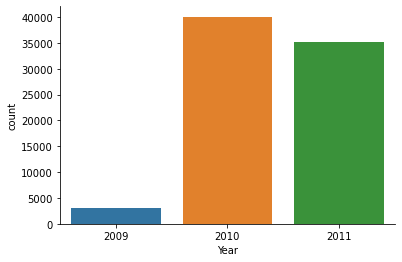

In [49]:
# Make countplots for datetime data
sns.countplot(x='Year', data=df)
sns.despine()

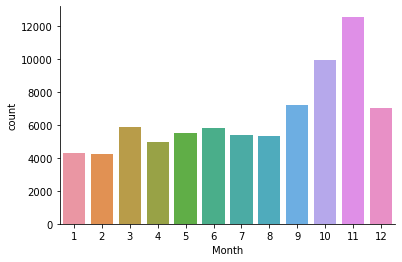

In [50]:
# Make countplots for datetime data
sns.countplot(x='Month', data=df)
sns.despine()

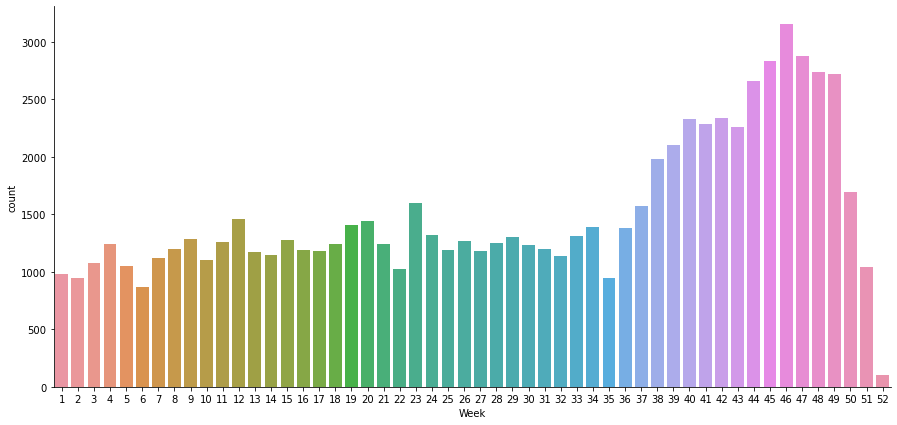

In [51]:
# Make countplots for datetime data
plt.figure(figsize=(15,7))
sns.countplot(x='Week', data=df)
sns.despine()

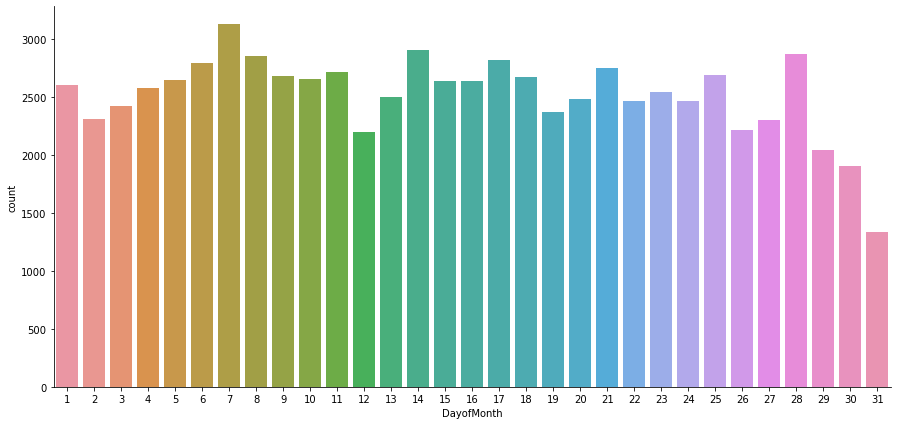

In [52]:
# Make countplots for datetime data
plt.figure(figsize=(15,7))
sns.countplot(x='DayofMonth', data=df)
sns.despine()

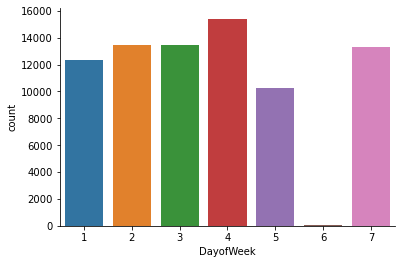

In [53]:
# Make countplots for datetime data. 
# Note that Monday is day 1.
sns.countplot(x='DayofWeek', data=df)
sns.despine()

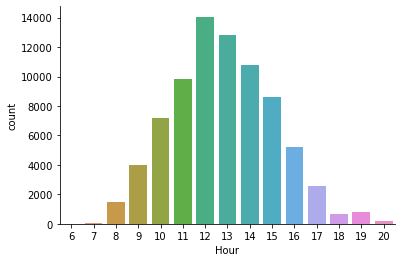

In [54]:
# Make countplots for datetime data
sns.countplot(x='Hour', data=df)
sns.despine()

# 6. Exploratory Data Analysis: Multivariate 

### a. Charts of numeric variables by categorical variables.

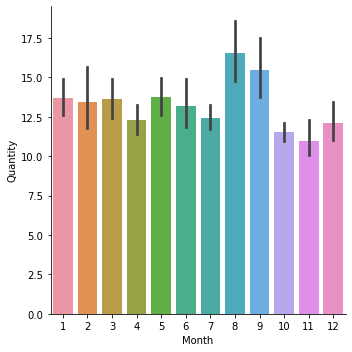

In [55]:
sns.catplot(x='Month', y='Quantity', data=df, kind='bar')

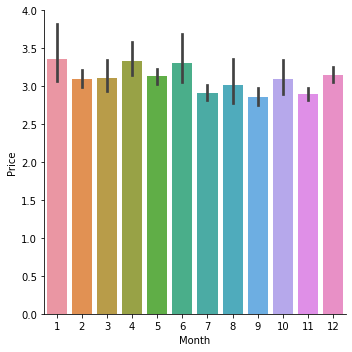

In [56]:
sns.catplot(x='Month', y='Price', data=df, kind='bar')

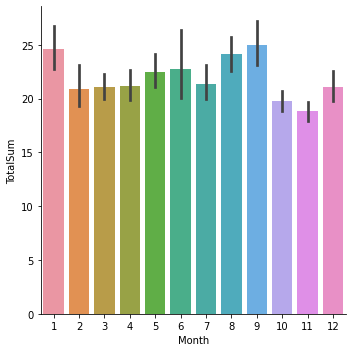

In [57]:
sns.catplot(x='Month', y='TotalSum', data=df, kind='bar')

### b. Charts of time series trends

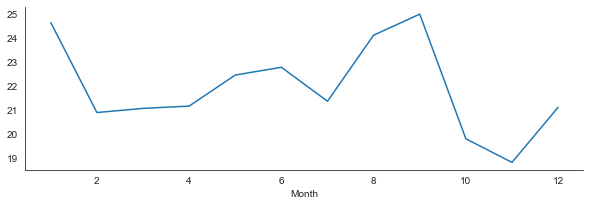

In [58]:
#Look at average total spent per customer per month of the year.
sns.set_style('white')
plt.figure(figsize=(10,3))
df.groupby('Month').mean()['TotalSum'].plot()
sns.despine()

### c. Look at the second Data Frame

In [59]:
df2.head()

,Revenue,Items Ordered,Average Price per Item,Total Orders
Dates,,,,
2009-12-01,3441.82,2093,2.993393,224
2009-12-02,4297.21,2409,3.047848,237
2009-12-03,7229.05,3877,3.055933,268
2009-12-04,3139.55,1871,2.609534,193
2009-12-05,1080.46,607,3.623953,43


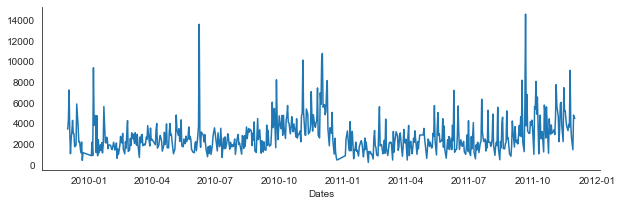

In [60]:
#Visualize total revenue per day
sns.set_style('white')
plt.figure(figsize=(10,3))
df2['Revenue'].plot()
sns.despine()

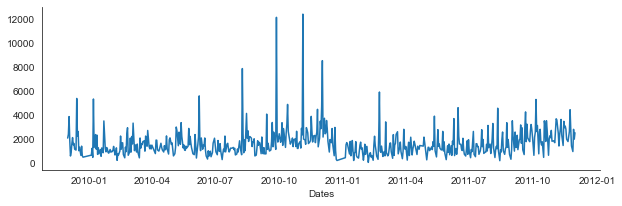

In [61]:
#Total items ordered per day
sns.set_style('white')
plt.figure(figsize=(10,3))
df2['Items Ordered'].plot()
sns.despine()

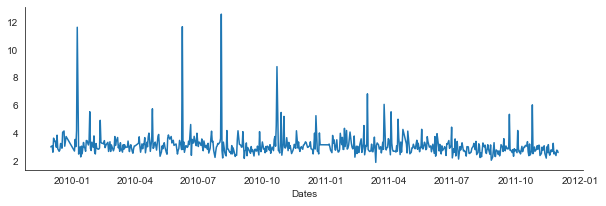

In [62]:
#Average price per item per day
sns.set_style('white')
plt.figure(figsize=(10,3))
df2['Average Price per Item'].plot()
sns.despine()

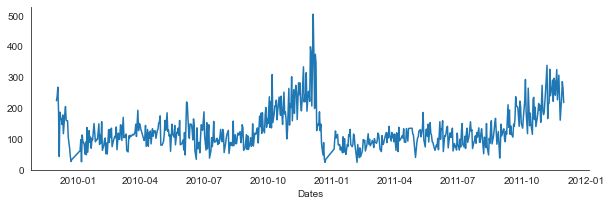

In [63]:
#Total Orders Received per day
sns.set_style('white')
plt.figure(figsize=(10,3))
df2['Total Orders'].plot()
sns.despine()

# 7. Prepare data for time series analyses

### a. Prepare dependent variable

In [64]:
# Rename dependent variable y
df2.rename(columns = {'Revenue': 'y'}, inplace=True)
df2.head(2)

,y,Items Ordered,Average Price per Item,Total Orders
Dates,,,,
2009-12-01,3441.82,2093,2.993393,224
2009-12-02,4297.21,2409,3.047848,237


In [65]:
#Set the index to have a daily frequency and look at the index
df2 = df2.asfreq("D")
df2.index

DatetimeIndex(['2009-12-01', '2009-12-02', '2009-12-03', '2009-12-04',
               '2009-12-05', '2009-12-06', '2009-12-07', '2009-12-08',
               '2009-12-09', '2009-12-10',
               ...
               '2011-11-21', '2011-11-22', '2011-11-23', '2011-11-24',
               '2011-11-25', '2011-11-26', '2011-11-27', '2011-11-28',
               '2011-11-29', '2011-11-30'],
              dtype='datetime64[ns]', name='Dates', length=730, freq='D')

In [66]:
#If we may be missing data for a day in the chart, fill in the blanks by taking the value of the day before to fill in the gap
df2.fillna(method='ffill', inplace=True)

<AxesSubplot:xlabel='Dates'>

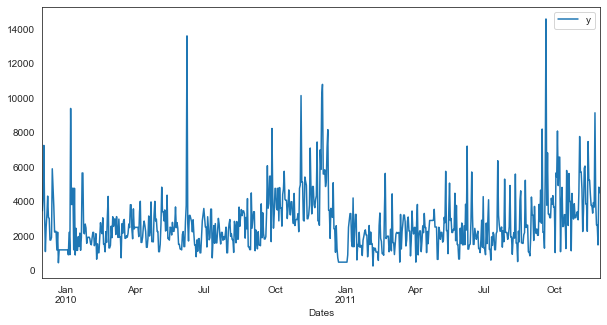

In [67]:
#Plot the dependent variable.
df2["y"].plot(figsize = (10,5), legend = True)

### b. Seasonal Decomposition

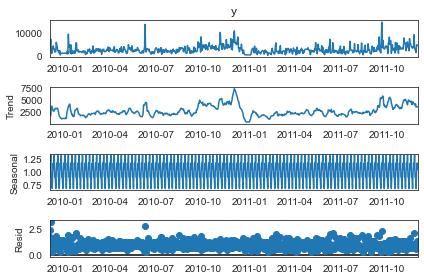

In [68]:
#Do a seasonal decomposition into Error, Trend, and Seasonality 
#Add a semicolon to prevent getting extra graphs
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(x=df2['y'],model='multiplicative', extrapolate_trend=365)
decomp.plot();

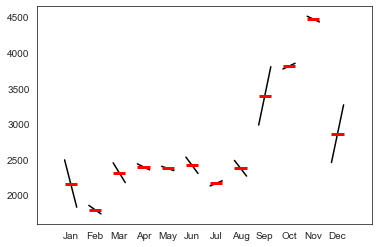

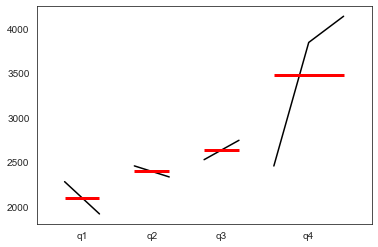

In [69]:
#Compute the mean for each month and plot a monthly seasonality graph
#Red lines are average; Black lines show volitility.
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
month_plot(df2['y'].resample(rule = 'MS').mean())
quarter_plot(df2['y'].resample(rule = 'Q').mean());

### c. Train Test Split

In [70]:
#For the train test split, split the timeline into a pre and post period. 
#Training set: Select all rows execept for the most recent 31 days and select all columns.
#Test set: Select just the last 31 days of rows and select all columns.
test_periods = 31
tng_set = df2.iloc[:-test_periods, : ]
test_set = df2.iloc[-test_periods:, : ]
test_set.tail()

,y,Items Ordered,Average Price per Item,Total Orders
Dates,,,,
2011-11-26,2623.67,1439.0,2.607391,161.0
2011-11-27,1463.90,976.0,2.370255,235.0
2011-11-28,4810.54,2819.0,2.757448,286.0
2011-11-29,4496.24,2006.0,2.733333,264.0
2011-11-30,4508.79,2533.0,2.588165,218.0


In [71]:
#Run the Dickey-Fuller test to test for stationarity. If p is less than 0.05, the time series is stationary; if not, you may need to zoom in to a smaller time frame.
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(df2['y'])
print('Augmented Dickey Fuller p-value: %F' % stationarity[1])

Augmented Dickey Fuller p-value: 0.010865


# 8. Forecasting Models

## a. Holt-Winters Triple Exponential Smoothing Forecast

In [72]:
#Remove unnecesary warnings
import warnings
warnings.filterwarnings("ignore")

#Holt-Winters Triple Exponential Smoothing
#State which is the dependent variable, specify that we have a trend and seasonality which may be additive or multiplicative, specify that the seasonal period is 7 days.
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW_model1 = ExponentialSmoothing(endog=tng_set['y'], trend = 'mul', seasonal ='mul', seasonal_periods = 7).fit()
HW_model2 = ExponentialSmoothing(endog=tng_set['y'], trend = 'add', seasonal ='add', seasonal_periods = 7).fit()
HW_model3 = ExponentialSmoothing(endog=tng_set['y'], trend = 'add', seasonal ='mul', seasonal_periods = 7).fit()
HW_model4 = ExponentialSmoothing(endog=tng_set['y'], trend = 'mul', seasonal ='add', seasonal_periods = 7).fit()

In [73]:
#Look at a summary of the model and see what the parameters are.
#The summary also shows you the coefficients of each variable.
HW_model1.summary()

Dep. Variable:,y,No. Observations:,699
Model:,ExponentialSmoothing,SSE,2002203826.101
Optimized:,True,AIC,10414.637
Trend:,Multiplicative,BIC,10464.683
Seasonal:,Multiplicative,AICC,10415.168
Seasonal Periods:,7,Date:,"Tue, 01 Nov 2022"
Box-Cox:,False,Time:,11:27:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2525000,alpha,True
smoothing_trend,0.0001000,beta,True


In [74]:
#Set the steps to indicate how far out to make the forecast. We'll predict for the number of rows of our test set.
#Get predictions using Holt Winters
pred_HW1_X = HW_model1.forecast(steps = len(test_set)).rename("Holt-Winters1")
pred_HW2_X = HW_model2.forecast(steps = len(test_set)).rename("Holt-Winters2")
pred_HW3_X = HW_model3.forecast(steps = len(test_set)).rename("Holt-Winters3")
pred_HW4_X = HW_model4.forecast(steps = len(test_set)).rename("Holt-Winters4")

pred_HW1_X.head(5)

2011-10-31    5087.293583
2011-11-01    6554.552510
2011-11-02    6000.630731
2011-11-03    8085.898915
2011-11-04    5661.964380
Freq: D, Name: Holt-Winters1, dtype: float64

## b. TBATS Forecast

In [75]:
#TBATS (Trigonometrics seasonality, Box-Cox transformation, AutoRegressive Moving Average, Trend, Seasonality)
#For the seasonal periods, put 7 for the week, 52 for weekly data, and 365.5 for the year. 
from tbats import TBATS
TBATS_model = TBATS(use_trend = True, seasonal_periods = [7,365.5]).fit(tng_set['y'])

In [76]:
#Look at a summary of the model and see what the parameters are.
#The summary also shows you the coefficients of each variable.
TBATS_model.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: True\nSeasonal periods: [  7.  365.5]\nSeasonal harmonics [3 1]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.000000\nSmoothing (Alpha): 0.413134\nTrend (Beta): -0.058710\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-3.43644809e-08  2.64203079e-08 -1.72030954e-08  1.69424469e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 7.39088531  0.08024313  0.09961968  0.05634473  0.01919413  0.19524523\n -0.07623468 -0.14262494  0.74501951 -0.17634111]\n\nAIC 14247.707812'

In [77]:
#Make predictions with TBATS
#For TBATS, you have to make it a series and borrow the index from the test set
pred_TBATS_X = pd.Series(TBATS_model.forecast(steps = len(test_set))).rename("TBATS")
pred_TBATS_X.index = test_set.index
pred_TBATS_X.head(5)

Dates
2011-10-31    3922.332058
2011-11-01    4594.336109
2011-11-02    4047.209237
2011-11-03    5070.936797
2011-11-04    3656.928821
Freq: D, Name: TBATS, dtype: float64

## c. SARIMAX Forecast

In [78]:
# Isolate the exogenous regressor variables. 
# Get all rows for all columns starting in the 3rd column
train_exog = tng_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]
test_exog.head()

,Items Ordered,Average Price per Item,Total Orders
Dates,,,
2011-10-31,1805.0,3.079215,191.0
2011-11-01,1711.0,2.824190,179.0
2011-11-02,2681.0,3.104064,187.0
2011-11-03,3693.0,3.109189,222.0
2011-11-04,3593.0,2.373629,259.0


In [79]:
#SARIMAX
!pip install pmdarima
from pmdarima import auto_arima
SARIMAX_model = auto_arima(y=tng_set['y'], X=train_exog,m=7, seasonal =True, stepwise = False)

In [80]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  699
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -5626.751
Date:                           Tue, 01 Nov 2022   AIC                          11271.501
Time:                                   11:32:27   BIC                          11312.448
Sample:                               12-01-2009   HQIC                         11287.331
                                    - 10-30-2011                                         
Covariance Type:                             opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -3.4664      5.471     -0.634      0.526     -14.190       7.257
Items Ordered              0.8789      0.012     73.611      0.000       0.856       0.902
Average Price per Item   174.6634     13.981     12.493      0.000     147.262     202.065
Total Orders               8.7664      0.573     15.291      0.000       7.643       9.890
ar.L1                      0.5137      0.221      2.329      0.020       0.081       0.946
ma.L1                     -0.4099      0.234     -1.752      0.080      -0.868       0.049
ar.S.L7                    0.9773      0.031     31.289      0.000       0.916       1.039
ma.S.L7                   -0.9268      0.051    -18.111      0.000      -1.027      -0.827
sigma2                  5.966e+05   1.31e+04     45.466      0.000    5.71e+05    6.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             46486.68
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             3.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
#Make predictions with SARIMAX. Also transform the array.
pred_SARIMAX_X = pd.Series(SARIMAX_model.predict(n_periods = test_periods, X=test_exog)).rename('SARIMAX')
pred_SARIMAX_X.index = test_set.index
pred_SARIMAX_X.head(5)

Dates
2011-10-31    3415.119417
2011-11-01    3632.381370
2011-11-02    4156.948734
2011-11-03    5611.284070
2011-11-04    5567.153475
Freq: D, Name: SARIMAX, dtype: float64

## d. Tensorflow Probabilities Structural Time Series Forecast

In [82]:
#Make a matrix to  get ready to isolate the regressors.
#We also need to change the columns with integers to be float.

import tensorflow_probability as tfp
exog = np.asmatrix(df2.iloc[:,1:].astype(np.float64))
exog[:1]

matrix([[2093.        ,    2.99339286,  224.        ]])

In [83]:
#Do a linear regression then isolate the dependent variable and take a look at the first 5 rows of it.
regressors = tfp.sts.LinearRegression(design_matrix=exog, name='regressors')
y = tng_set['y'].astype(np.float64)
y[:5]

Dates
2009-12-01    3441.82
2009-12-02    4297.21
2009-12-03    7229.05
2009-12-04    3139.55
2009-12-05    1080.46
Freq: D, Name: y, dtype: float64

In [84]:
#Specify that we have weekday seasonality (7 days in a week). 
#Since we have hourly data, we'll put 24 in where it says num steps per season.
weekday_effect = tfp.sts.Seasonal(num_seasons=7, num_steps_per_season=24, observed_time_series=y, name = 'weekday_effect')

In [85]:
#Add monthly seasonality. 
#Use the number of days per month for each year. Make sure to change February to have 29 days if a leap year.
num_days_per_month = np.array([[31,29,31,30,31,30,31,31,30,31,30,31],  
                               [31,28,31,30,31,30,31,31,30,31,30,31],
                               [31,28,31,30,31,30,31,31,30,31,30,31]])
monthly_effect = tfp.sts.Seasonal(num_seasons=12, num_steps_per_season=num_days_per_month, observed_time_series=y, name = 'monthly_effect')   

In [86]:
#Add trend component and autoregressive component
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,name="trend")
autoregressive = tfp.sts.Autoregressive(order = 1, observed_time_series=y,name="autoregressive")

In [87]:
#Combine all components.
TSTS_model = tfp.sts.Sum([regressors, weekday_effect, monthly_effect, autoregressive, trend], observed_time_series=y)

In [88]:
#Fit with Hamiltonian Monte Carlo (HMC)
#To speed up the analysis, but get a bad result, set the numbers to be low, but your predictions will be bad.
samples, kernel_results = tfp.sts.fit_with_hmc(model=TSTS_model, observed_time_series=y, num_results = 50, num_warmup_steps=15, num_leapfrog_steps=10, num_variational_steps=20, seed=1502)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [89]:
#Make a forecast with Tensorflow 
#Make a data frame of predictions and take a look at a couple of them.
forecastTSTS =tfp.sts.forecast(model=TSTS_model, observed_time_series=y, parameter_samples=samples, num_steps_forecast = len(test_set))
pred_TSTS_X=pd.Series(forecastTSTS.mean()[:,0], name='TSTS')
pred_TSTS_X.index = test_set.index
pred_TSTS_X[:2]

Dates
2011-10-31    3447.585776
2011-11-01    3515.352330
Freq: D, Name: TSTS, dtype: float64

## e. Facebook Prophet

In [90]:
#Import libraries for FB Prophet and XG Boost
import itertools
from prophet import Prophet
import xgboost as xgb

In [91]:
#Create a column with dates from the index of dates
df2['ds']=df2.index
df2.head()

,y,Items Ordered,Average Price per Item,Total Orders,ds
Dates,,,,,
2009-12-01,3441.82,2093.0,2.993393,224.0,2009-12-01
2009-12-02,4297.21,2409.0,3.047848,237.0,2009-12-02
2009-12-03,7229.05,3877.0,3.055933,268.0,2009-12-03
2009-12-04,3139.55,1871.0,2.609534,193.0,2009-12-04
2009-12-05,1080.46,607.0,3.623953,43.0,2009-12-05


In [92]:
#Create a new column for holidays and add a 1 to any dates we want to consider
df2['Holidays']=""
holiday_dates=['2010-6-12','2010-6-18','2010-6-23','2010-6-27']
df2.loc[holiday_dates,'Holidays']=1
df2.head()

,y,Items Ordered,Average Price per Item,Total Orders,ds,Holidays
Dates,,,,,,
2009-12-01,3441.82,2093.0,2.993393,224.0,2009-12-01,
2009-12-02,4297.21,2409.0,3.047848,237.0,2009-12-02,
2009-12-03,7229.05,3877.0,3.055933,268.0,2009-12-03,
2009-12-04,3139.55,1871.0,2.609534,193.0,2009-12-04,
2009-12-05,1080.46,607.0,3.623953,43.0,2009-12-05,


In [93]:
#Make a Holidays data frame
#Take a look at all dates that have a 1 in the 'holiday' column, but just return the dates from the ds column
#Ask FB Prophet to look at 3 days in the past and 1 day in the future for each holiday
h_dates=df2[df2['Holidays']==1].ds
holidays=pd.DataFrame({'holiday':'World Cup','ds':pd.to_datetime(h_dates), 'lower_window':-3, 'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
Dates,,,,
2010-06-12,World Cup,2010-06-12,-3,1
2010-06-18,World Cup,2010-06-18,-3,1
2010-06-23,World Cup,2010-06-23,-3,1
2010-06-27,World Cup,2010-06-27,-3,1


In [94]:
#Add a ds column to the training set and to the test set for Facebook Prophet
tng_set['ds']=tng_set.index
test_set['ds']=test_set.index
tng_set.head()

,y,Items Ordered,Average Price per Item,Total Orders,ds
Dates,,,,,
2009-12-01,3441.82,2093.0,2.993393,224.0,2009-12-01
2009-12-02,4297.21,2409.0,3.047848,237.0,2009-12-02
2009-12-03,7229.05,3877.0,3.055933,268.0,2009-12-03
2009-12-04,3139.55,1871.0,2.609534,193.0,2009-12-04
2009-12-05,1080.46,607.0,3.623953,43.0,2009-12-05


In [95]:
#Facebook Prophet model
#Add regressor columns to the model
#Fit the Model
FBP_model=Prophet(growth='linear', 
          yearly_seasonality=True, 
          weekly_seasonality=True,
          daily_seasonality=True, 
          holidays = holidays, 
          seasonality_mode='multiplicative', 
          seasonality_prior_scale=10, 
          holidays_prior_scale=10, 
          changepoint_prior_scale=0.05)
FBP_model.add_country_holidays(country_name='UK')
FBP_model.add_regressor('Items Ordered')
FBP_model.add_regressor('Average Price per Item')
FBP_model.add_regressor('Total Orders')
FBP_model.fit(tng_set)

11:39:35 - cmdstanpy - INFO - Chain [1] start processing
11:39:35 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
#Create a future data frame
future1=FBP_model.make_future_dataframe(periods=len(test_set), freq='D')
future1

,ds
0,2009-12-01
1,2009-12-02
2,2009-12-03
3,2009-12-04
4,2009-12-05
...,...
725,2011-11-26
726,2011-11-27
727,2011-11-28
728,2011-11-29


In [97]:
#Add variables to the future data frame from a previous data frame. 
#Need to reset old data frame's index for the new data frame.
df3=df2[['Items Ordered','Average Price per Item','Total Orders']].reset_index()
df3.head(2)

,Dates,Items Ordered,Average Price per Item,Total Orders
0,2009-12-01,2093.0,2.993393,224.0
1,2009-12-02,2409.0,3.047848,237.0


In [98]:
#Make a data frame of just the regressor columns
future2=pd.concat([future1,df3.iloc[:,1:4]], axis=1)
future2.head(5)

,ds,Items Ordered,Average Price per Item,Total Orders
0,2009-12-01,2093.0,2.993393,224.0
1,2009-12-02,2409.0,3.047848,237.0
2,2009-12-03,3877.0,3.055933,268.0
3,2009-12-04,1871.0,2.609534,193.0
4,2009-12-05,607.0,3.623953,43.0


In [99]:
#Make predictions with Facebook Prophet
#The result will show you predictions in the "yhat" column.
#This will also let you study the regressor columns.
forecast1=FBP_model.predict(future2)
forecast1.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Average Price per Item,Average Price per Item_lower,Average Price per Item_upper,Battle of the Boyne [Northern Ireland],...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-12-01,3349.438652,3813.93664,5581.122239,3349.438652,3349.438652,-0.013957,-0.013957,-0.013957,0.0,...,0.092485,0.092485,0.092485,0.157652,0.157652,0.157652,0.0,0.0,0.0,4739.614216


In [100]:
#Make predictions for the last 31 days
#Then look at the last 5 days
test_days=31
pred_FBP_X = forecast1.yhat[-test_days:].rename('FB Prophet')
pred_FBP_X[:5]

699    3467.928299
700    3695.218094
701    4482.487853
702    5962.322106
703    5889.138562
Name: FB Prophet, dtype: float64

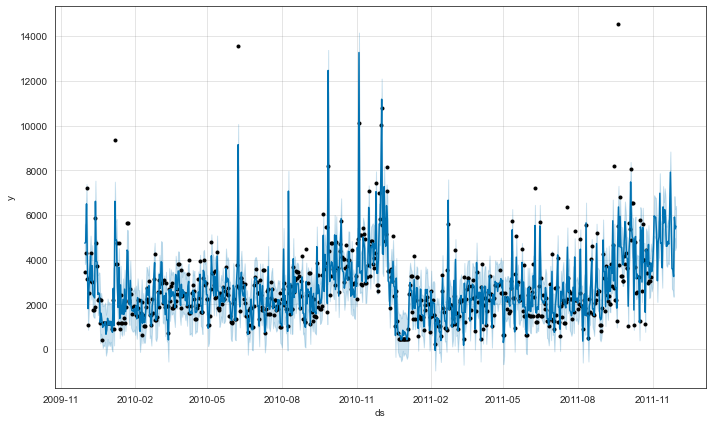

In [101]:
#Visualization of the forecast
#Blue is our time series and the black dots are our forecast.
FBP_model.plot(forecast1);

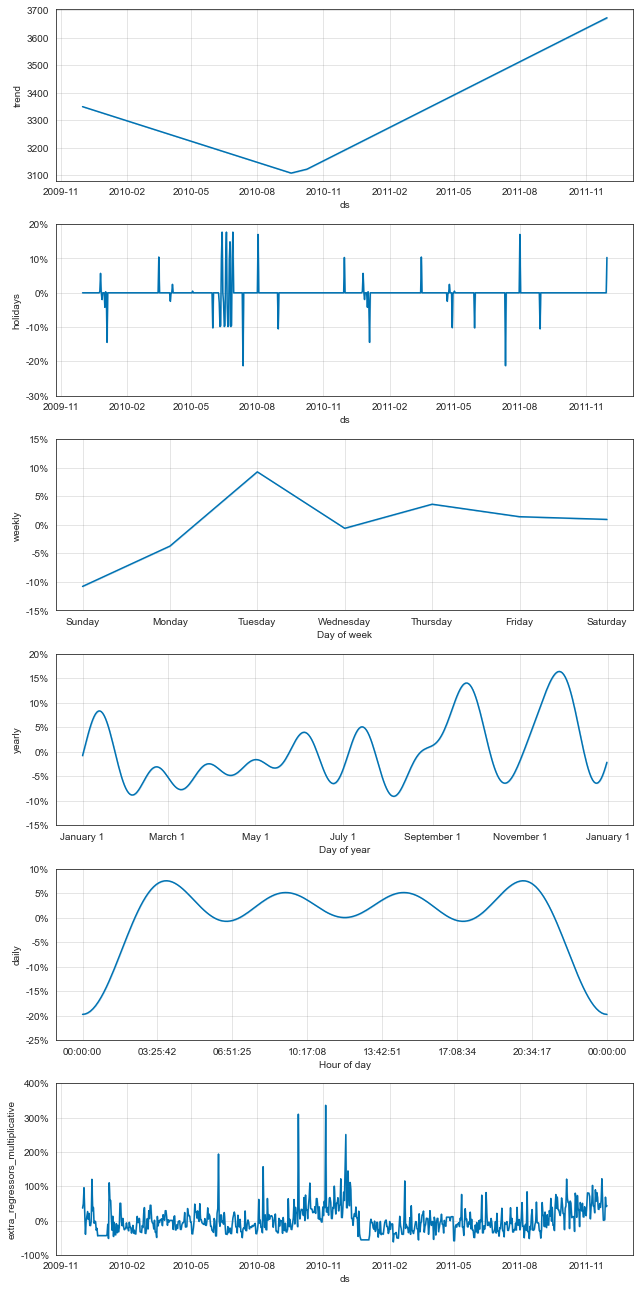

In [102]:
#plot components
FBP_model.plot_components(forecast1);

In [103]:
#For FBP, we'll make it a series and borrow the index from the test set. This gets us ready to add it to another graph.
pred_FBP_X = pd.Series(pred_FBP_X).rename("FBP")
pred_FBP_X.index = test_set.index
pred_FBP_X.head(5)

Dates
2011-10-31    3467.928299
2011-11-01    3695.218094
2011-11-02    4482.487853
2011-11-03    5962.322106
2011-11-04    5889.138562
Freq: D, Name: FBP, dtype: float64

### f. FB Prophet with Hyperparameter Tuning

In [104]:
#First, do a cross validation using the historical data.
#This will train and evaluate the model several times.
#Horizon is how many days you are forcasting for each iteration.
#Initial is when to start the cross validation. We'll do a year and a half.
from prophet.diagnostics import cross_validation
df_cv=cross_validation(FBP_model, horizon='31 days', initial='547 days', parallel = 'processes')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-06-13,1795.175944,1071.025766,2506.939664,1512.32,2011-06-12 12:00:00
1,2011-06-14,2695.579493,2002.413841,3375.078400,2836.75,2011-06-12 12:00:00
2,2011-06-15,6769.848611,6086.061530,7436.346523,5691.27,2011-06-12 12:00:00
3,2011-06-16,4158.348900,3550.485362,4837.609054,3161.52,2011-06-12 12:00:00
4,2011-06-17,2537.912711,1773.771024,3250.354153,1494.97,2011-06-12 12:00:00
...,...,...,...,...,...,...
243,2011-10-26,4188.949515,3275.808191,5115.527928,2964.23,2011-09-29 00:00:00
244,2011-10-27,5198.059503,4300.155482,6110.803364,3852.99,2011-09-29 00:00:00
245,2011-10-28,3615.502101,2689.012519,4523.485032,3045.68,2011-09-29 00:00:00
246,2011-10-29,3611.901705,2654.167407,4523.784281,3045.68,2011-09-29 00:00:00


In [105]:
#Get performance metrics
from prophet.diagnostics import performance_metrics
performance_metrics_results = performance_metrics(df_cv)
performance_metrics_results

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days 00:00:00,1.055485e+06,1027.368206,701.229959,0.360302,0.192061,0.291238,0.583333
1,3 days 12:00:00,1.040304e+06,1019.953036,689.638409,0.315878,0.185529,0.261270,0.583333
2,4 days 00:00:00,1.130269e+06,1063.141280,757.923621,0.324075,0.204873,0.271309,0.458333
3,4 days 12:00:00,5.055102e+05,710.992433,625.743072,0.316335,0.228008,0.256689,0.500000
4,5 days 00:00:00,5.300894e+05,728.072380,642.406080,0.326121,0.250289,0.264530,0.458333
5,5 days 12:00:00,6.607619e+05,812.872647,710.071223,0.330872,0.254574,0.273969,0.416667
6,6 days 00:00:00,5.747488e+05,758.121882,637.981834,0.261494,0.235005,0.224980,0.583333
7,6 days 12:00:00,3.853470e+06,1963.025749,1006.661606,0.298456,0.245161,0.269043,0.541667
8,7 days 00:00:00,3.859883e+06,1964.658437,998.818858,0.302510,0.245161,0.266936,0.583333
9,7 days 12:00:00,3.869055e+06,1966.991339,1018.184250,0.299731,0.239290,0.266384,0.541667


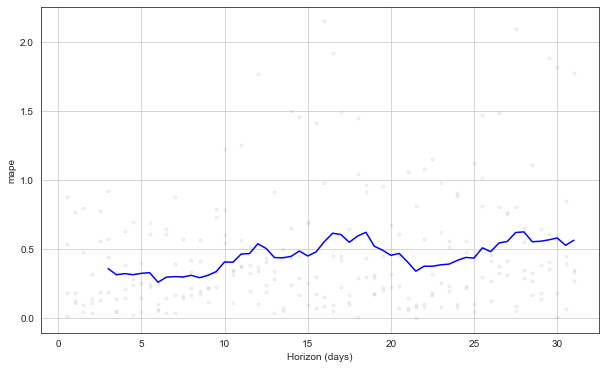

In [106]:
#Visualize the percent error for when forecasts are for a short time horizon into the future versus a longer time horizon into the future.
#The blue line is the MAPE
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [107]:
#Evaluate cross validation predictions with RMSE, MAE, and MAPE.
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#Do RMSE and round it
evalCVa=round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])),1) 
evalA = [evalCVa]
labels = ['FBP CV']
RMSE_CV = pd.DataFrame(evalA,labels,['RMSE'])

#Do MAE and round it.
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
evalCVb=round(mean_absolute_error(df_cv['y'], df_cv['yhat']),1)
evalB = [evalCVb]
labels = ['FBP CV']
MAE_CV = pd.DataFrame(evalB,labels,['MAE'])

#Do MAPE and round it
def MAPE(y_true,y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true))*100
evalCVc=round(MAPE(df_cv['y'],df_cv['yhat']),1)
evalC = [evalCVc]
labels = ['FBP CV']
MAPE_CV = pd.DataFrame(evalC,labels,['MAPE'])

#Put RMSE, MAE, and MAPE together in a table.
eval_CV = pd.DataFrame()
eval_CV ['RMSE']=RMSE_CV
eval_CV ['MAE']=MAE_CV
eval_CV ['MAPE']=MAPE_CV
eval_CV.sort_values(['RMSE'],ascending=True)

,RMSE,MAE,MAPE
FBP CV,1355.7,998.8,45.3


In [108]:
#Make a grid of parameters. We'll add the parameters we want and the range of values to test for each one.
#Look at a few of the combinations of parameters
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [0.01, 5, 10, 20],
              'changepoint_prior_scale': [0.001, 0.05, 0.1, 0.5],
              'holidays_prior_scale': [0.01, 5, 10, 20],
              'seasonality_mode': ['additive', 'multiplicative']}
grid = ParameterGrid(param_grid)
list(grid)[:4]   

[{'changepoint_prior_scale': 0.001,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.001,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.001,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20}]

In [109]:
#Hyperparameter tuning
#Create a blank list to add RMSE results to
#Copy and paste the previously built Facebook Prophet model.
#Have the parameters to be tested reference the parameters grid.
#Build a model for each set of parameters in the parameter grid
#Do cross validation for each model and compare them with RMSE.
#This will take time to run depending on how many combinations of parameters there are.
RMSE=[]
for params in grid:
    FBP_model=Prophet(growth='linear',
          yearly_seasonality=True, 
          weekly_seasonality=True,
          daily_seasonality=True, 
          holidays = holidays, 
          seasonality_mode=params['seasonality_mode'], 
          seasonality_prior_scale=params['seasonality_prior_scale'], 
          holidays_prior_scale=params['holidays_prior_scale'], 
          changepoint_prior_scale=params['changepoint_prior_scale'])
    FBP_model.add_country_holidays(country_name='UK')
    FBP_model.add_regressor('Items Ordered')
    FBP_model.add_regressor('Average Price per Item')
    FBP_model.add_regressor('Total Orders')
    FBP_model.fit(tng_set)
    df_cv=cross_validation(FBP_model, horizon='31 days', initial='547 days', parallel = 'processes')
    RMSE_result = np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
    RMSE.append(RMSE_result)

11:39:58 - cmdstanpy - INFO - Chain [1] start processing
11:39:58 - cmdstanpy - INFO - Chain [1] done processing
11:40:11 - cmdstanpy - INFO - Chain [1] start processing
11:40:11 - cmdstanpy - INFO - Chain [1] done processing
11:40:24 - cmdstanpy - INFO - Chain [1] start processing
11:40:24 - cmdstanpy - INFO - Chain [1] done processing
11:40:37 - cmdstanpy - INFO - Chain [1] start processing
11:40:37 - cmdstanpy - INFO - Chain [1] done processing
11:40:52 - cmdstanpy - INFO - Chain [1] start processing
11:40:52 - cmdstanpy - INFO - Chain [1] done processing
11:41:11 - cmdstanpy - INFO - Chain [1] start processing
11:41:11 - cmdstanpy - INFO - Chain [1] done processing
11:42:43 - cmdstanpy - INFO - Chain [1] start processing
11:42:43 - cmdstanpy - INFO - Chain [1] done processing
11:43:05 - cmdstanpy - INFO - Chain [1] start processing
11:43:05 - cmdstanpy - INFO - Chain [1] done processing
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1]

12:00:03 - cmdstanpy - INFO - Chain [1] done processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing
12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:50 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:22 - cmdstanpy - INFO - Chain [1] start processing
12:01:23 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] 

In [110]:
#Get the best parameters from the hyper parameter tuning
best_params = grid[np.argmin(RMSE)]
print(best_params)

{'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.05}


In [111]:
#Run the model with the best parameters
FBP_tuned_model=Prophet(growth='linear',
          yearly_seasonality=True, 
          weekly_seasonality=True,
          daily_seasonality=True, 
          holidays = holidays, 
          seasonality_mode=best_params['seasonality_mode'], 
          seasonality_prior_scale=best_params['seasonality_prior_scale'], 
          holidays_prior_scale=best_params['holidays_prior_scale'], 
          changepoint_prior_scale=best_params['changepoint_prior_scale'])
FBP_tuned_model.add_country_holidays(country_name='UK')
FBP_tuned_model.add_regressor('Items Ordered')
FBP_tuned_model.add_regressor('Average Price per Item')
FBP_tuned_model.add_regressor('Total Orders')
FBP_tuned_model.fit(tng_set)

12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
#Get ready to forecast with Facebook Prophet.
#Create Future data frame
#Add variables to future data frame from a previous data frame. 
#Need to reset old data frame's index for the new data frame.
#Make a data frame of just the regressor columns

future_FBP_tuned_1=FBP_tuned_model.make_future_dataframe(periods=len(test_set), freq='D')
future_FBP_tuned_2=df2[['Items Ordered','Average Price per Item','Total Orders']].reset_index()
future_FBP_tuned_reg=pd.concat([future_FBP_tuned_1,future_FBP_tuned_2.iloc[:,1:4]], axis=1)
future_FBP_tuned_reg.head(5)

,ds,Items Ordered,Average Price per Item,Total Orders
0,2009-12-01,2093.0,2.993393,224.0
1,2009-12-02,2409.0,3.047848,237.0
2,2009-12-03,3877.0,3.055933,268.0
3,2009-12-04,1871.0,2.609534,193.0
4,2009-12-05,607.0,3.623953,43.0


In [113]:
#Make predictions with Facebook Prophet
#The result will show you predictions in the "yhat" column.
#This will also let you study the regressor columns.
forecast_FB_tuned=FBP_tuned_model.predict(future_FBP_tuned_reg)
forecast_FB_tuned.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Average Price per Item,Average Price per Item_lower,Average Price per Item_upper,Battle of the Boyne [Northern Ireland],...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-12-01,2726.277459,3231.005071,5194.376012,2726.277459,2726.277459,-0.017642,-0.017642,-0.017642,0.0,...,0.034347,0.034347,0.034347,0.034085,0.034085,0.034085,0.0,0.0,0.0,4230.005543


In [114]:
#Make predictions for the last 31 days
test_days=31
pred_FBP_tuned_X= forecast_FB_tuned.yhat[-test_days:].rename('FBP Tuned')

#For FBP, we'll make it a series and borrow the index from the test set. This gets us ready to add it to another graph.
pred_FBP_tuned_X = pd.Series(pred_FBP_tuned_X).rename("FBP Tuned")
pred_FBP_tuned_X.index = test_set.index
pred_FBP_tuned_X.head(5)

Dates
2011-10-31    3676.397166
2011-11-01    3541.431937
2011-11-02    4615.129424
2011-11-03    6039.021646
2011-11-04    6047.711611
Freq: D, Name: FBP Tuned, dtype: float64

## g. Facebook Prophet with XGBoost

In [115]:
#Look at what columns we have from FB Prophet
forecast_FB_tuned.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Average Price per Item', 'Average Price per Item_lower',
       'Average Price per Item_upper',
       'Battle of the Boyne [Northern Ireland]',
       'Battle of the Boyne [Northern Ireland]_lower',
       'Battle of the Boyne [Northern Ireland]_upper', 'Boxing Day',
       'Boxing Day_lower', 'Boxing Day_upper', 'Boxing Day (Observed)',
       'Boxing Day (Observed)_lower', 'Boxing Day (Observed)_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper',
       'Easter Monday [England/Wales/Northern Ireland]',
       'Easter Monday [England/Wales/Northern Ireland]_lower',
       'Easter Monday [England/Wales/Northern Ireland]_upper', 'Good Friday',
       'Good Friday_lower', 'Good Friday_upper', 'Items Ordered',
       'Items Ordered_lower', 'Items Ordered_upper',
     

In [116]:
#Get the FB Prophet columns that we want and add them to the original data frame.
#Make sure to reset the index of df2 so that it can match the FB forecast data frame's index before combining them.
prophet_variables = forecast_FB_tuned.loc[:, ['trend','weekly', 'yearly']]
df_xgb = pd.concat([df2.reset_index(), prophet_variables], axis=1)
df_xgb.head(2)

,Dates,y,Items Ordered,Average Price per Item,Total Orders,ds,Holidays,trend,weekly,yearly
0,2009-12-01,3441.82,2093.0,2.993393,224.0,2009-12-01,,2726.277459,0.034347,0.034085
1,2009-12-02,4297.21,2409.0,3.047848,237.0,2009-12-02,,2725.433315,-0.002930,0.033519


In [117]:
#Get the column titles to have ready to copy and paste into the order we want
df_xgb.columns

Index(['Dates', 'y', 'Items Ordered', 'Average Price per Item', 'Total Orders',
       'ds', 'Holidays', 'trend', 'weekly', 'yearly'],
      dtype='object')

In [118]:
#Remove or reorder any columns we want to change
df_xgb = df_xgb [['ds','y', 'Items Ordered', 'Average Price per Item', 'Total Orders', 'trend', 'weekly', 'yearly']]
df_xgb.head(2)

,ds,y,Items Ordered,Average Price per Item,Total Orders,trend,weekly,yearly
0,2009-12-01,3441.82,2093.0,2.993393,224.0,2726.277459,0.034347,0.034085
1,2009-12-02,4297.21,2409.0,3.047848,237.0,2725.433315,-0.002930,0.033519


In [119]:
#Make sure that each column has the numeric datatype that XGBoost likes.
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      730 non-null    datetime64[ns]
 1   y                       730 non-null    float64       
 2   Items Ordered           730 non-null    float64       
 3   Average Price per Item  730 non-null    float64       
 4   Total Orders            730 non-null    float64       
 5   trend                   730 non-null    float64       
 6   weekly                  730 non-null    float64       
 7   yearly                  730 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 45.8 KB


In [120]:
#Do another Train Test Split
#Training set: Select all rows execept for the most recent 31 days and select all columns.
#Test set: Select just the last 31 days of rows and select all columns.
test_periods = 31
tng_set_xgb = df_xgb.iloc[:-test_periods, : ]
test_set_xgb = df_xgb.iloc[-test_periods:, : ]
test_set_xgb.head(5)

,ds,y,Items Ordered,Average Price per Item,Total Orders,trend,weekly,yearly
699,2011-10-31,3390.71,1805.0,3.079215,191.0,2934.000455,-0.015137,-0.018774
700,2011-11-01,2919.31,1711.0,2.824190,179.0,2935.084696,0.034347,-0.016320
701,2011-11-02,4536.01,2681.0,3.104064,187.0,2936.168936,-0.002930,-0.013865
702,2011-11-03,7745.11,3693.0,3.109189,222.0,2937.253177,0.009150,-0.011434
703,2011-11-04,5690.86,3593.0,2.373629,259.0,2938.337417,0.008284,-0.009048


In [121]:
#Isolate X and Y variables
y_train_xgb = tng_set_xgb['y']
y_test_xgb = test_set_xgb['y']
X_train_xgb = tng_set_xgb.iloc[:,2:]
X_test_xgb = test_set_xgb.iloc[:,2:]
X_train_xgb.head()

,Items Ordered,Average Price per Item,Total Orders,trend,weekly,yearly
0,2093.0,2.993393,224.0,2726.277459,0.034347,0.034085
1,2409.0,3.047848,237.0,2725.433315,-0.002930,0.033519
2,3877.0,3.055933,268.0,2724.589172,0.009150,0.032598
3,1871.0,2.609534,193.0,2723.745028,0.008284,0.031319
4,607.0,3.623953,43.0,2722.900884,0.006775,0.029686


In [122]:
#Create XGBoost Matrices
Train = xgb.DMatrix(data= X_train_xgb, label = y_train_xgb)
Test = xgb.DMatrix(data= X_test_xgb, label = y_test_xgb)

In [123]:
#Set the parameters for the XG Boost model
XGB_parameters = {'learning_rate': 0.1,
              'max_depth': 3, 
              'colsample_bytree': 1,
              'subsample':1,
              'min_child_weight':1,
              'gamma':1,
              'random_state': 101,
              'eval_metric':"rmse",
              'objective': "reg:squarederror"}

In [124]:
#XGBoost Model
XGB_model = xgb.train(params=XGB_parameters, dtrain=Train, num_boost_round=100, evals=[(Test,"y")], verbose_eval = 15)

[0]	y-rmse:4266.85894
[15]	y-rmse:1084.06783
[30]	y-rmse:670.85686
[45]	y-rmse:668.08898
[60]	y-rmse:681.71781
[75]	y-rmse:688.47943
[90]	y-rmse:691.61641
[99]	y-rmse:691.16237


In [125]:
#Make predictions with Facebook plus XG Boost and put it into a data frame with an index of dates
#Look at just the first two rows
pred_XGB_X = pd.Series(XGB_model.predict(data=Test), name="XGB")
pred_XGB_X.index =test_set_xgb['ds']
pred_XGB_X[:2]

ds
2011-10-31    3250.121338
2011-11-01    2985.477051
Name: XGB, dtype: float32

### h. Ensemble Forecast 

<AxesSubplot:xlabel='ds'>

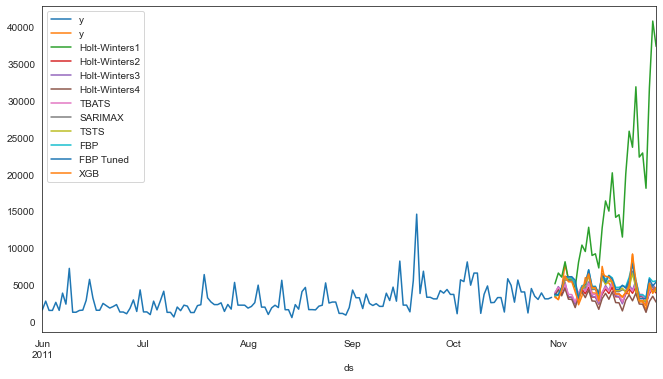

In [126]:
#Visualize all forecasts.
#Look at just the data starting at a certain date until the end of the data.
tng_set['y']['2011-6-01':].plot(figsize=(11,6),legend=True)
test_set['y'].plot(figsize=(11,6),legend=True)
pred_HW1_X.plot(legend = True)
pred_HW2_X.plot(legend = True)
pred_HW3_X.plot(legend = True)
pred_HW4_X.plot(legend = True)
pred_TBATS_X.plot(legend = True)
pred_SARIMAX_X.plot(legend = True)
pred_TSTS_X.plot(legend = True)
pred_FBP_X.plot(legend = True)
pred_FBP_tuned_X.plot(legend = True)
pred_XGB_X.plot(legend = True)

In [127]:
#Evaluate predictions with RMSE, MAE, and MAPE.
#Do RMSE
evalHWa1=np.sqrt(mean_squared_error(test_set['y'], pred_HW1_X))
evalHWa2=np.sqrt(mean_squared_error(test_set['y'], pred_HW2_X))
evalHWa3=np.sqrt(mean_squared_error(test_set['y'], pred_HW3_X))
evalHWa4=np.sqrt(mean_squared_error(test_set['y'], pred_HW4_X))
evalTBATSa=np.sqrt(mean_squared_error(test_set['y'], pred_TBATS_X))
evalSARIMAXa=np.sqrt(mean_squared_error(test_set['y'], pred_SARIMAX_X))
evalTSTSa=np.sqrt(mean_squared_error(test_set['y'], pred_TSTS_X))
evalFBPa=np.sqrt(mean_squared_error(test_set['y'], pred_FBP_X)) 
evalFBPTa=np.sqrt(mean_squared_error(test_set['y'], pred_FBP_tuned_X))
evalXGBa=np.sqrt(mean_squared_error(test_set['y'], pred_XGB_X))
evalA = [evalHWa1,evalHWa2,evalHWa3,evalHWa4,evalTBATSa,evalSARIMAXa,evalTSTSa,evalFBPa,evalFBPTa,evalXGBa]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS', 'SARIMAX', 'TSTS', 'FBP', 'FBP Tuned', 'XGB']
RMSE_evals = pd.DataFrame(evalA,labels,['RMSE'])

#Do MAE  
evalHWb1=mean_absolute_error(test_set['y'], pred_HW1_X)
evalHWb2=mean_absolute_error(test_set['y'], pred_HW2_X)
evalHWb3=mean_absolute_error(test_set['y'], pred_HW3_X)
evalHWb4=mean_absolute_error(test_set['y'], pred_HW4_X)
evalTBATSb=mean_absolute_error(test_set['y'], pred_TBATS_X)
evalSARIMAXb=mean_absolute_error(test_set['y'], pred_SARIMAX_X)
evalTSTSb=mean_absolute_error(test_set['y'], pred_TSTS_X)
evalFBPb=mean_absolute_error(test_set['y'], pred_FBP_X)
evalFBPTb=mean_absolute_error(test_set['y'], pred_FBP_tuned_X)
evalXGBb=mean_absolute_error(test_set['y'], pred_XGB_X)
evalB = [evalHWb1,evalHWb2,evalHWb3,evalHWb4,evalTBATSb,evalSARIMAXb,evalTSTSb,evalFBPb,evalFBPTb,evalXGBb]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS','SARIMAX','TSTS','FBP','FBP Tuned','XGB']
MAE_evals = pd.DataFrame(evalB,labels,['MAE'])

#Do MAPE  
def MAPE(y_true,y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true))*100
evalHWc1=MAPE(test_set['y'],pred_HW1_X)
evalHWc2=MAPE(test_set['y'],pred_HW2_X)
evalHWc3=MAPE(test_set['y'],pred_HW3_X)
evalHWc4=MAPE(test_set['y'],pred_HW4_X)
evalTBATSc=MAPE(test_set['y'],pred_TBATS_X)
evalSARIMAXc=MAPE(test_set['y'],pred_SARIMAX_X)
evalTSTSXc=MAPE(test_set['y'],pred_TSTS_X)
evalFBPc=MAPE(test_set['y'],pred_FBP_X)
evalFBPTc=MAPE(test_set['y'],pred_FBP_tuned_X)
evalXGBc=MAPE(test_set['y'],pred_XGB_X)
evalC = [evalHWc1,evalHWc2,evalHWc3,evalHWc4,evalTBATSc,evalSARIMAXc,evalTSTSXc,evalFBPc,evalFBPTc,evalXGBc]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS','SARIMAX','TSTS','FBP','FBP Tuned','XGB']
MAPE_evals = pd.DataFrame(evalC,labels,['MAPE'])

#Put RMSE, MAE, MAPE, and Total Revenue Forecast together in a table and select the best prediction.
evals = pd.DataFrame()
evals['RMSE']=RMSE_evals
evals['MAE']=MAE_evals
evals['MAPE']=MAPE_evals
evals.sort_values(['RMSE'],ascending=True).applymap('{:,.2f}'.format)

,RMSE,MAE,MAPE
XGB,691.16,532.48,13.19
SARIMAX,918.08,692.63,17.80
TSTS,928.35,693.89,18.35
FBP Tuned,993.42,873.94,24.08
FBP,"1,118.52",992.52,27.61
TBATS,"1,596.58","1,181.60",27.15
Holt-Winters 3,"1,634.74","1,236.96",28.02
Holt-Winters 2,"1,718.46","1,270.92",27.61
Holt-Winters 4,"2,086.23","1,592.04",32.57
Holt-Winters 1,"14,985.19","11,303.60",310.83


In [128]:
#Concatenate the best predictions from the 6 main types of forecasts
df_ensemble = pd.concat([test_set['y'], pred_HW3_X, pred_TBATS_X, pred_SARIMAX_X, pred_TSTS_X, pred_FBP_tuned_X, pred_XGB_X], axis = 1)
df_ensemble.head()

,y,Holt-Winters3,TBATS,SARIMAX,TSTS,FBP Tuned,XGB
2011-10-31,3390.71,3773.582972,3922.332058,3415.119417,3447.585776,3676.397166,3250.121338
2011-11-01,2919.31,4712.892144,4594.336109,3632.381370,3515.352330,3541.431937,2985.477051
2011-11-02,4536.01,4050.980600,4047.209237,4156.948734,4515.215848,4615.129424,4255.848633
2011-11-03,7745.11,5273.174787,5070.936797,5611.284070,5697.782311,6039.021646,6147.749023
2011-11-04,5690.86,3356.326335,3656.928821,5567.153475,5820.451411,6047.711611,5360.677734


In [129]:
#Average the forecasts from each column for each day and put the results in a new column.
df_ensemble["Ensemble"] = df_ensemble.iloc[:,1:].mean(axis = 1)
df_ensemble.head()

,y,Holt-Winters3,TBATS,SARIMAX,TSTS,FBP Tuned,XGB,Ensemble
2011-10-31,3390.71,3773.582972,3922.332058,3415.119417,3447.585776,3676.397166,3250.121338,3580.856454
2011-11-01,2919.31,4712.892144,4594.336109,3632.381370,3515.352330,3541.431937,2985.477051,3830.311824
2011-11-02,4536.01,4050.980600,4047.209237,4156.948734,4515.215848,4615.129424,4255.848633,4273.555413
2011-11-03,7745.11,5273.174787,5070.936797,5611.284070,5697.782311,6039.021646,6147.749023,5639.991439
2011-11-04,5690.86,3356.326335,3656.928821,5567.153475,5820.451411,6047.711611,5360.677734,4968.208231


In [130]:
#Put the ensemble predictions into a data frame and name it for your graph
#Look at just the first two rows
pred_Ensemble_X = pd.Series(df_ensemble["Ensemble"], name="Ensemble")
pred_Ensemble_X[:2]

2011-10-31    3580.856454
2011-11-01    3830.311824
Freq: D, Name: Ensemble, dtype: float64

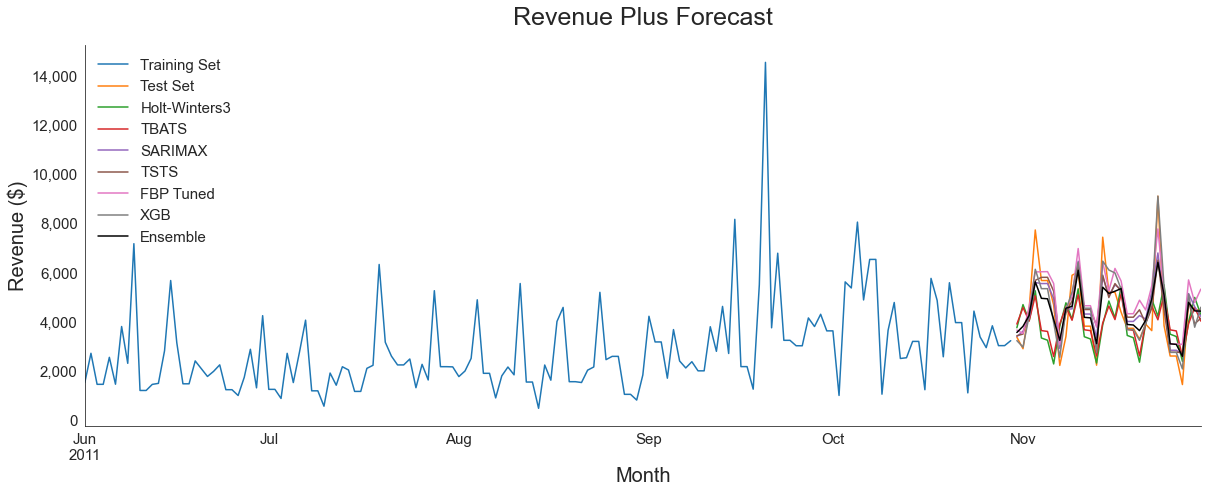

In [154]:
#Visualize the top six forecasts plus the ensemble forecast.
#Look at just the results starting at a certain date until the end of the data.

tng_set['y']['2011-6-01':].plot(figsize=(20,7),legend=True, xlabel='Month', ylabel='Revenue', label='Training Set')
test_set['y'].plot(figsize=(20,7),legend=True, label='Test Set')
pred_HW3_X.plot(legend = True)
pred_TBATS_X.plot(legend = True)
pred_SARIMAX_X.plot(legend = True)
pred_TSTS_X.plot(legend = True)
pred_FBP_tuned_X.plot(legend = True)
pred_XGB_X.plot(legend = True, xlabel='Month')
pred_Ensemble_X.plot(legend = True, color='black')
plt.legend(loc='upper left', borderaxespad=.5, frameon=False, fontsize=15)


#Set labels
plt.ylabel("Revenue ($)", size=20)
plt.xlabel("Month", size=20)
plt.title("Revenue Plus Forecast", size=25, pad=20)
plt.tick_params(axis='both', which='major', labelsize=15)

#Format the y axis numbers
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

sns.set_style('white')
sns.despine()

In [132]:
#Evaluate predictions with RMSE, MAE, and MAPE and see Revenue forecast.

#Do RMSE
evalHWa1=np.sqrt(mean_squared_error(test_set['y'], pred_HW1_X))
evalHWa2=np.sqrt(mean_squared_error(test_set['y'], pred_HW2_X))
evalHWa3=np.sqrt(mean_squared_error(test_set['y'], pred_HW3_X))
evalHWa4=np.sqrt(mean_squared_error(test_set['y'], pred_HW4_X))
evalTBATSa=np.sqrt(mean_squared_error(test_set['y'], pred_TBATS_X))
evalSARIMAXa=np.sqrt(mean_squared_error(test_set['y'], pred_SARIMAX_X))
evalTSTSa=np.sqrt(mean_squared_error(test_set['y'], pred_TSTS_X))
evalFBPa=np.sqrt(mean_squared_error(test_set['y'], pred_FBP_X)) 
evalFBPTa=np.sqrt(mean_squared_error(test_set['y'], pred_FBP_tuned_X))
evalXGBa=np.sqrt(mean_squared_error(test_set['y'], pred_XGB_X))
evalEnsemblea=np.sqrt(mean_squared_error(test_set['y'], pred_Ensemble_X))
evalA = [evalHWa1,evalHWa2,evalHWa3,evalHWa4,evalTBATSa,evalSARIMAXa,evalTSTSa,evalFBPa,evalFBPTa,evalXGBa,evalEnsemblea]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS', 'SARIMAX', 'TSTS', 'FBP', 'FBP Tuned', 'XGB', 'Ensemble']
RMSE_evals = pd.DataFrame(evalA,labels,['RMSE'])

#Do MAE  
evalHWb1=mean_absolute_error(test_set['y'], pred_HW1_X)
evalHWb2=mean_absolute_error(test_set['y'], pred_HW2_X)
evalHWb3=mean_absolute_error(test_set['y'], pred_HW3_X)
evalHWb4=mean_absolute_error(test_set['y'], pred_HW4_X)
evalTBATSb=mean_absolute_error(test_set['y'], pred_TBATS_X)
evalSARIMAXb=mean_absolute_error(test_set['y'], pred_SARIMAX_X)
evalTSTSb=mean_absolute_error(test_set['y'], pred_TSTS_X)
evalFBPb=mean_absolute_error(test_set['y'], pred_FBP_X)
evalFBPTb=mean_absolute_error(test_set['y'], pred_FBP_tuned_X)
evalXGBb=mean_absolute_error(test_set['y'], pred_XGB_X)
evalEnsembleb=mean_absolute_error(test_set['y'], pred_Ensemble_X)
evalB = [evalHWb1,evalHWb2,evalHWb3,evalHWb4,evalTBATSb,evalSARIMAXb,evalTSTSb,evalFBPb,evalFBPTb,evalXGBb,evalEnsembleb]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS','SARIMAX','TSTS','FBP','FBP Tuned','XGB', 'Ensemble']
MAE_evals = pd.DataFrame(evalB,labels,['MAE'])

#Do MAPE  
def MAPE(y_true,y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true))*100
evalHWc1=MAPE(test_set['y'],pred_HW1_X)
evalHWc2=MAPE(test_set['y'],pred_HW2_X)
evalHWc3=MAPE(test_set['y'],pred_HW3_X)
evalHWc4=MAPE(test_set['y'],pred_HW4_X)
evalTBATSc=MAPE(test_set['y'],pred_TBATS_X)
evalSARIMAXc=MAPE(test_set['y'],pred_SARIMAX_X)
evalTSTSXc=MAPE(test_set['y'],pred_TSTS_X)
evalFBPc=MAPE(test_set['y'],pred_FBP_X)
evalFBPTc=MAPE(test_set['y'],pred_FBP_tuned_X)
evalXGBc=MAPE(test_set['y'],pred_XGB_X)
evalEnsemblec=MAPE(test_set['y'],pred_Ensemble_X)
evalC = [evalHWc1,evalHWc2,evalHWc3,evalHWc4,evalTBATSc,evalSARIMAXc,evalTSTSXc,evalFBPc,evalFBPTc,evalXGBc,evalEnsemblec]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS','SARIMAX','TSTS','FBP','FBP Tuned','XGB', 'Ensemble']
MAPE_evals = pd.DataFrame(evalC,labels,['MAPE'])

#Forecast the Revenue for the forecast period and round it.
revHWb1=pred_HW1_X.sum()
revHWb2=pred_HW2_X.sum()
revHWb3=pred_HW3_X.sum()
revHWb4=pred_HW4_X.sum()
revTBATS=pred_TBATS_X.sum()
revSARIMAX=pred_SARIMAX_X.sum()
revTSTS=pred_TSTS_X.sum()   
revFBP=pred_FBP_X.sum()    
revFBPT=pred_FBP_tuned_X.sum()    
revXGB=pred_XGB_X.sum()
revEnsemble=df_ensemble["Ensemble"].sum()
rev = [revHWb1,revHWb2,revHWb3,revHWb4,revTBATS,revSARIMAX,revTSTS,revFBP,revFBPT,revXGB,revEnsemble]
labels = ['Holt-Winters 1','Holt-Winters 2', 'Holt-Winters 3', 'Holt-Winters 4', 'TBATS','SARIMAX','TSTS','FBP','FBP Tuned','XGB', 'Ensemble']
Rev_forecast = pd.DataFrame(rev,labels,['Revenue Forecast'])

#Put RMSE, MAE, MAPE, and Total Revenue Forecast together in a table and select the best prediction.
evals = pd.DataFrame()
evals['RMSE']=RMSE_evals
evals['MAE']=MAE_evals
evals['MAPE']=MAPE_evals
evals['Revenue Forecast']=Rev_forecast 
evals.sort_values(['RMSE'],ascending=True).applymap('{:,.2f}'.format)

,RMSE,MAE,MAPE,Revenue Forecast
XGB,691.16,532.48,13.19,"141,053.44"
SARIMAX,918.08,692.63,17.80,"140,923.57"
TSTS,928.35,693.89,18.35,"141,113.03"
Ensemble,971.14,707.17,17.88,"137,148.54"
FBP Tuned,993.42,873.94,24.08,"153,618.87"
FBP,"1,118.52",992.52,27.61,"157,106.51"
TBATS,"1,596.58","1,181.60",27.15,"123,456.20"
Holt-Winters 3,"1,634.74","1,236.96",28.02,"122,726.16"
Holt-Winters 2,"1,718.46","1,270.92",27.61,"114,004.52"
Holt-Winters 4,"2,086.23","1,592.04",32.57,"93,449.00"


In [133]:
#Get the actual revenue that occurred during the 31-day test set period
Rev_test_set=round(test_set['y'].sum(),2)
Rev_test_set

136369.29

In [134]:
#Get the revenue from the Ensemble forecast
revEnsemble=round(df_ensemble["Ensemble"].sum(),2)
revEnsemble

137148.54

In [135]:
#Calculate the difference in dollars between the actual revenue and the forecasted revenue.
rev_diff=round(Rev_test_set-revEnsemble,2)
rev_diff

-779.25

In [136]:
#Get a percentage of how far off our forecast was
percent_diff =round(((Rev_test_set-revEnsemble)/Rev_test_set),3)
percent_diff 

-0.006

In [137]:
#Play a beep when the code is done running
winsound.Beep(550, 1000)

# 9. Interpret Results

In [138]:
#RQ 1: Based on past data, what total revenue do we forecast for the next month?
#Answer: 
    #The Ensemble Forecast predicted the last month's revenue to be $137,360.58. 
    #The test set's actual revenue for that last month was $136,369.29.
    #Our forecast was less than 1% off from the actual result. 

In [139]:
#Export the Forecast
#df_ensemble.to_csv('Forecast.csv', index=True)